In [6]:
import sys
import json
import pandas as pd
import seaborn as sns
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
root = Path.cwd().parent
sys.path.append(str(root))
plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern"})

from configs.materials import materials
from train import Trainer

In [7]:
mat_names = materials.keys()

train_inp_names = [
    'bl_ms_42_200',
    'combined_42_200',
    'gp_42_200',
    'pd_ms_42_200',
    'rw_42_200'
]

eval_inp_names = [
    'amplitude',
    'cyclic',
    'impulse',
    'piecewise',
    'resolution'
]

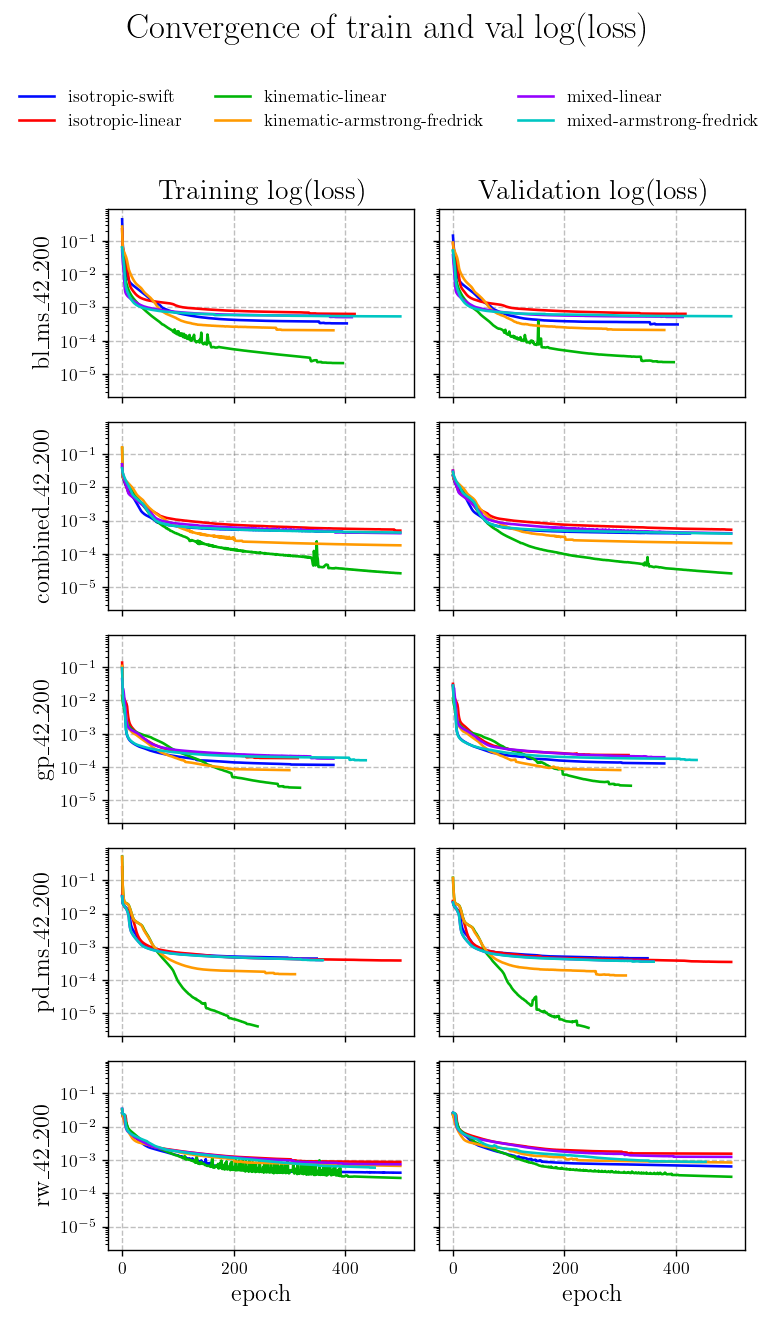

In [ ]:
fig, ax = plt.subplots(
    len(train_inp_names), 2, 
    figsize=(6, 2*len(train_inp_names)),
    dpi=125,
    sharey=True, sharex=True
)

for i, train_inp_name in enumerate(train_inp_names):
    
    ax[0][0].set_title('Training log(loss)',fontsize=16)
    ax[0][1].set_title('Validation log(loss)',fontsize=16)
    ax[-1][0].set_xlabel('epoch',fontsize=14)
    ax[-1][1].set_xlabel('epoch',fontsize=14)
    
    
    for mat_name in mat_names:
        
        for model_dir in Path('..','metrics',mat_name,train_inp_name).glob("MLP-incr-8-5-3*"):
            
            if model_dir.exists():
                trainer = Trainer(
                    mat_name,train_inp_name,
                    config_path='../configs/train.yaml',
                    data_dir='../data',
                )
                trainer.load(model_dir/'model.pth')
                ax[i][0].semilogy(trainer.train_losses, label=mat_name, color=materials[mat_name]['color'], lw=1.5)
                ax[i][1].semilogy(trainer.val_losses, label=mat_name, color=materials[mat_name]['color'], lw=1.5)


    ax[i][0].set_ylabel(train_inp_name,fontsize=14)
    ax[i][0].grid(ls='--',color='gray',alpha=0.5)
    ax[i][1].grid(ls='--',color='gray',alpha=0.5)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='upper center',
           ncol=3,
           bbox_to_anchor=(0.5, 1.0),   # a bit below the suptitle
           frameon=False)

fig.suptitle('Convergence of train and val log(loss)', fontsize=20, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.975])  # leave top space

# plt.savefig(Path('..','metrics','convergence.png'))
plt.show()

In [9]:
measure = 'RMSE'

cols = ['mat_name', 'train_set'] + eval_inp_names + train_inp_names

results_loc = []
results_glob = []
for mat_name, train_inp_name in product(mat_names,train_inp_names):
    for model_dir in Path('..','metrics',mat_name,train_inp_name).glob("MLP-incr-8-5-3*"):
        
        trainer = Trainer(
            mat_name,train_inp_name,
            config_path='../configs/train.yaml',
            data_dir='../data',
        )
        trainer.load(model_dir/'model.pth')
        
        line_loc = [mat_name, train_inp_name]
        line_glob = [mat_name, train_inp_name]

        with open(Path(model_dir,'eval_metrics.json'),'rb') as f:
            error_metrics = json.load(f)

        for eval_inp_name in eval_inp_names + train_inp_names:
            line_loc.append(error_metrics[eval_inp_name]['local'][measure])
            line_glob.append(error_metrics[eval_inp_name]['global'][measure])
        
        results_loc.append(line_loc)
        results_glob.append(line_glob)

df_loc = pd.DataFrame(results_loc, columns=cols)
df_glob = pd.DataFrame(results_glob, columns=cols)

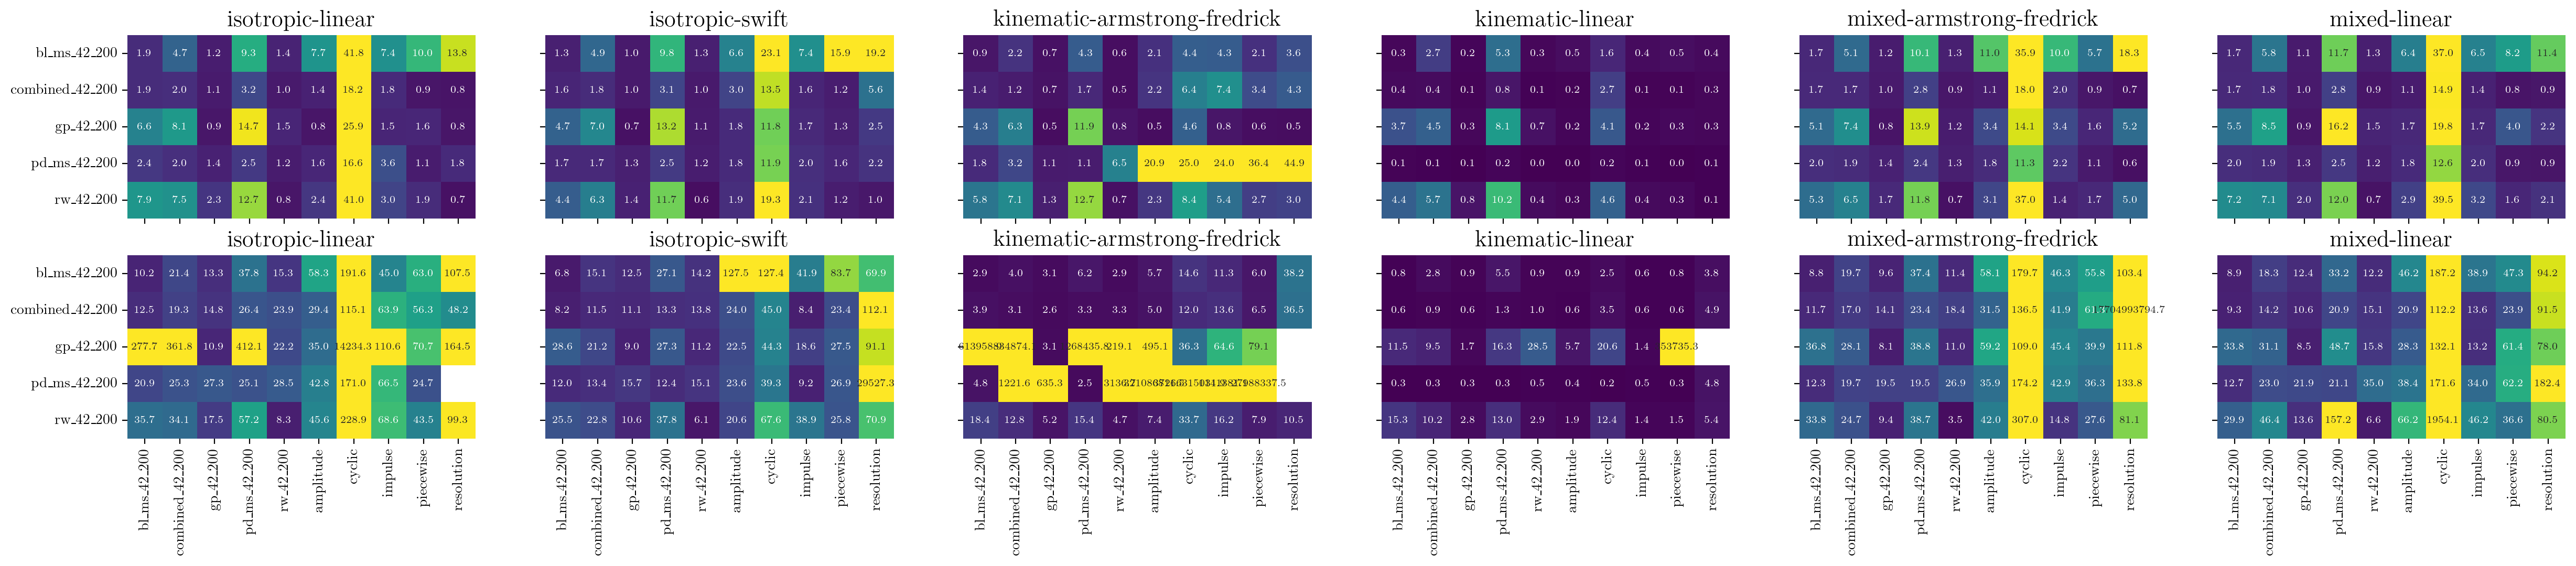

In [10]:
fig, ax = plt.subplots(2, 6, figsize=(30, 5), dpi=200, sharex=True, sharey=True)

for i,df in enumerate([df_loc, df_glob]):

    for j, (name, group) in enumerate(df.groupby('mat_name')):
        mx = group[['train_set'] + train_inp_names + eval_inp_names].set_index('train_set')/1e6

        ax[i,j].set_title(name, fontsize=16)

        sns.heatmap( mx,annot=True,fmt=".1f",cmap="viridis",
            ax=ax[i,j],cbar=False,annot_kws={"size":7},vmin=0, vmax= 100 if i else 15)

        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")

plt.show()

Check the kinematic linear model, trained on gp on piecewise and resolution, the local error is small, why the global is that high.

Check what is the cause of the large local error in the case of the armsrong fredrick.

In [ ]:
from data.materials import load_responses
import torch
model_prefix = 'MLP-incr-8-5-3'

def find_max_idx(y_p):  # y_p: (S, T, F)
    # Flatten to (S*T*F)
    max_idx = torch.argmax(y_p)
    
    # Recover indices
    S, T, F = y_p.shape
    sample_idx = max_idx // (T * F)
    rem = max_idx % (T * F)
    time_idx = rem // F
    feature_idx = rem % F
    
    return sample_idx, time_idx, feature_idx

def find_dir_with_prefix(directory, prefix):
    return [f for f in Path(directory).iterdir() if f.is_dir() and f.name.startswith(prefix)]

def pred_vs_truth(mat_name,train_inp_name,eval_inp_type,eval_inp_name):
    u_list, y_list = load_responses(
        mat_name,eval_inp_type,eval_inp_name,
        data_dir='../data'
    )

    parent_dir = Path('..','metrics',mat_name,train_inp_name)
    model_dir = find_dir_with_prefix(parent_dir,'MLP-incr-8-5-3')[0]
    
    trainer = Trainer(
        mat_name,train_inp_name,
        config_path='../configs/train.yaml',
        data_dir='../data',
    )
    trainer.load(model_dir/'model.pth')
    
    y_p = trainer.model.rollout(u_list,y_list[:,:8,:])
    y_t = y_list

    idx = find_max_idx(y_p)[0]

    return y_t.detach().numpy(), y_p.detach().numpy(), idx

In [28]:
y_t, y_p, idx  = pred_vs_truth(
    mat_name = 'kinematic-armstrong-fredrick',
    train_inp_name = 'pd_ms_42_200',
    eval_inp_type = 'static',
    eval_inp_name = 'cyclic',
)
plt.plot(y_t[idx],lw=2,c='black',marker='.')
plt.plot(y_p[idx],ls='--',lw=1,c='red',marker='.')
plt.xlim(0,17)
plt.ylim(0,2e8)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../metrics/kinematic-armstrong-fredrick/pd_ms_42_200/../metrics/kinematic-armstrong-fredrick/pd_ms_42_200/MLP-incr-8-5-3-38/model.pth'

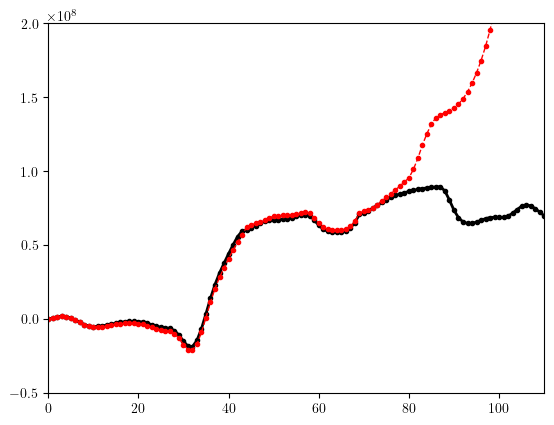

In [24]:
y_t, y_p, idx  = pred_vs_truth(
    mat_name = 'kinematic-armstrong-fredrick',
    train_inp_name = 'pd_ms_42_200',
    eval_inp_type = 'random',
    eval_inp_name = 'rw_42_200',
)

plt.plot(y_t[idx],lw=2,c='black',marker='.')
plt.plot(y_p[idx],ls='--',lw=1,c='red',marker='.')
plt.xlim(0,110)
plt.ylim(-5e7,2e8)
plt.show()

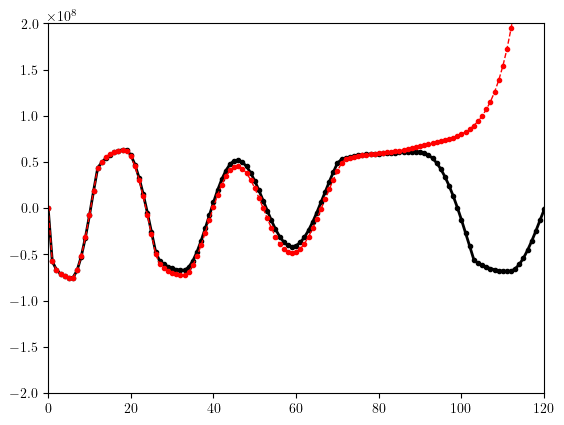

In [25]:
y_t, y_p, idx  = pred_vs_truth(
    mat_name = 'kinematic-armstrong-fredrick',
    train_inp_name = 'pd_ms_42_200',
    eval_inp_type = 'random',
    eval_inp_name = 'gp_42_200',
)

plt.plot(y_t[idx],lw=2,c='black',marker='.')
plt.plot(y_p[idx],ls='--',lw=1,c='red',marker='.')
plt.xlim(0,120)
plt.ylim(-2e8,2e8)
plt.show()

In [26]:
y_t, y_p, idx  = pred_vs_truth(
    mat_name = 'kinematic-linear',
    train_inp_name = 'gp_42_200',
    eval_inp_type = 'static',
    eval_inp_name = 'piecewise',
)

plt.plot(y_t[idx],lw=2,c='black',marker='.')
plt.plot(y_p[idx],ls='--',lw=1,c='red',marker='.')
plt.xlim(0,150)
plt.ylim(0,2e8)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../metrics/kinematic-linear/gp_42_200/MLP-incr-8-5-3-38/model.pth'

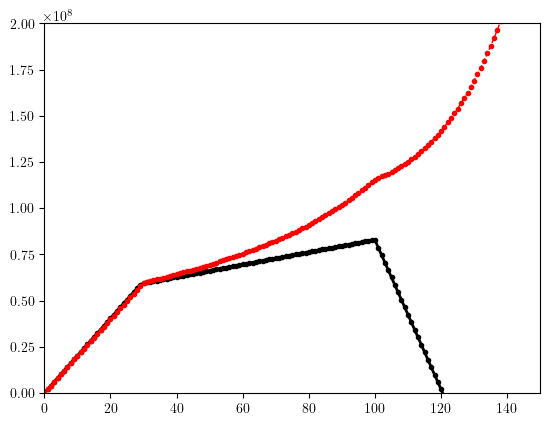

In [83]:
plt.plot(y_list.detach().numpy()[series_idx],lw=2,c='black',marker='.')
plt.plot(y_pred.detach().numpy()[series_idx],ls='--',lw=1,c='red',marker='.')
plt.xlim(0,150)
plt.ylim(0,2e8)
plt.show()

In [9]:
df_loc_melt = df_loc.melt(id_vars=['mat_name','train_set'], var_name='eval_set', value_name=measure)
df_glob_melt = df_glob.melt(id_vars=['mat_name','train_set'], var_name='eval_set', value_name=measure)

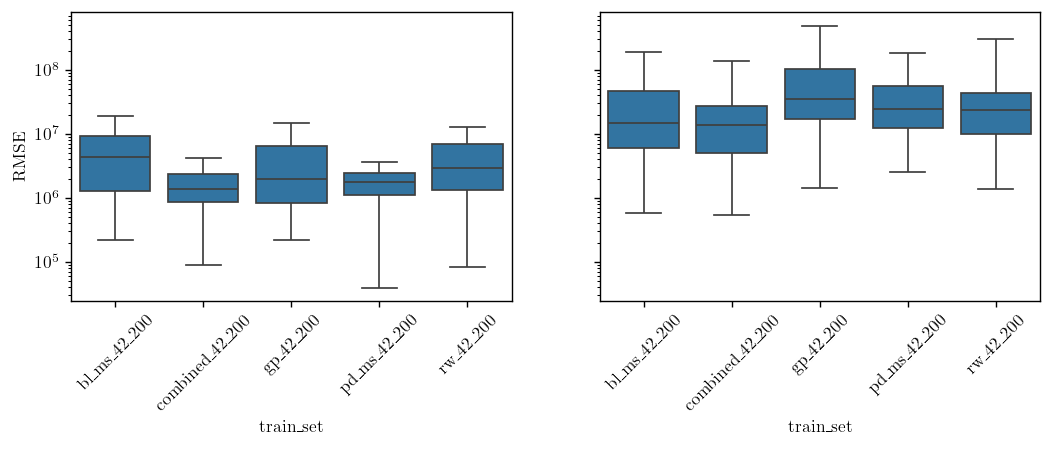

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,3),dpi=125,sharex=True,sharey=True)

for ax, df in zip(axes,[df_loc_melt, df_glob_melt]):
    sns.boxplot(data=df, x='train_set', y=measure, showfliers=False, ax=ax)
    ax.set_yscale('log')
    ax.tick_params(axis='x', rotation=45)

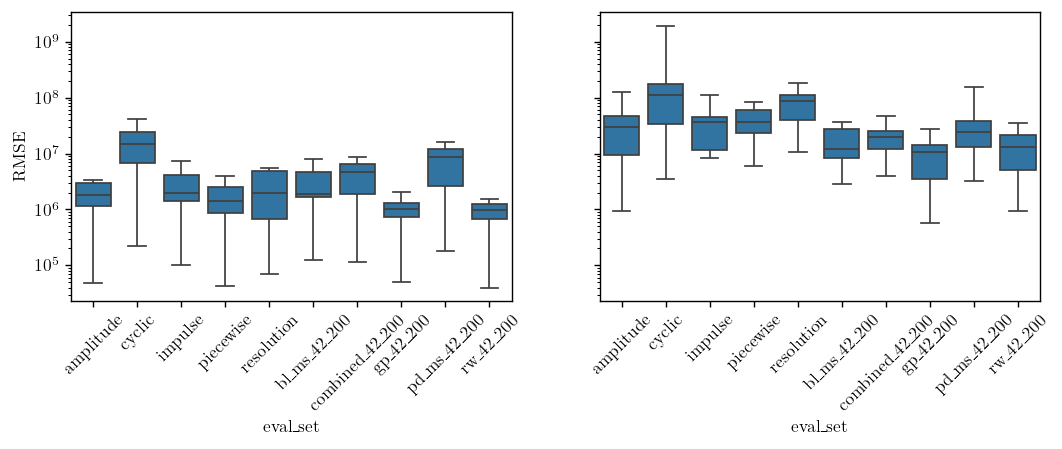

In [11]:
fig, axes = plt.subplots(1,2,figsize=(10,3),dpi=125,sharex=True,sharey=True)

for ax, df in zip(axes,[df_loc_melt, df_glob_melt]):
    sns.boxplot(data=df, x='eval_set', y=measure, showfliers=False, ax=ax)
    ax.set_yscale('log')
    ax.tick_params(axis='x', rotation=45)

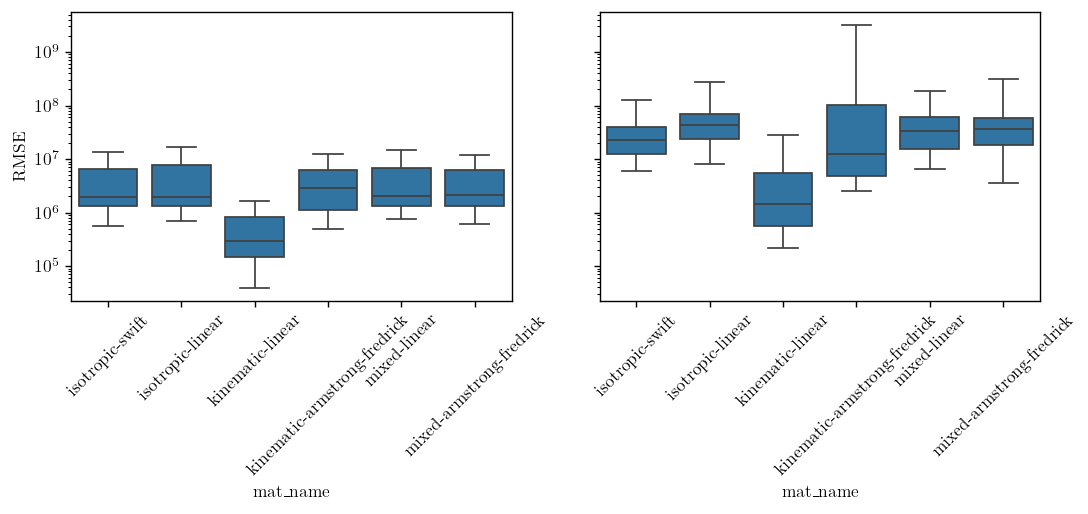

In [12]:
fig, axes = plt.subplots(1,2,figsize=(10,3),dpi=125,sharex=True,sharey=True)

for ax, df in zip(axes,[df_loc_melt, df_glob_melt]):
    sns.boxplot(data=df, x='mat_name', y=measure, showfliers=False, ax=ax)
    ax.set_yscale('log')
    ax.tick_params(axis='x', rotation=45)

In [13]:
df_glob_melt.groupby('eval_set')['RMSE'].mean().sort_values(ascending=True)/1e6

eval_set
gp_42_200          3.086153e+01
rw_42_200          1.238372e+02
bl_ms_42_200       2.048844e+04
combined_42_200    2.789758e+04
impulse            3.807666e+04
pd_ms_42_200       4.232050e+04
piecewise          9.447691e+05
amplitude          1.070294e+07
cyclic             1.242211e+09
resolution                  inf
Name: RMSE, dtype: float64

In [14]:
df_glob_melt.groupby('train_set')['RMSE'].mean().sort_values(ascending=True)/1e6

train_set
bl_ms_42_200       3.721311e+01
rw_42_200          6.973442e+01
combined_42_200    2.950833e+08
gp_42_200                   inf
pd_ms_42_200                inf
Name: RMSE, dtype: float64

In [15]:
df_glob_melt.groupby('mat_name')['RMSE'].mean().sort_values(ascending=True)/1e6

mat_name
mixed-linear                    8.642398e+01
isotropic-swift                 6.223964e+02
mixed-armstrong-fredrick        3.540999e+08
kinematic-armstrong-fredrick    7.837345e+08
isotropic-linear                         inf
kinematic-linear                         inf
Name: RMSE, dtype: float64